# Tutorial to compute the vertical evolution of gas with exogas
For a full description of the model see Marino et al. 2022 (submitted). 

We start by importing the usual python packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib
import time #import gmtime, strftime

import exogas.vertical_simulation as vsim
from exogas.constants import *

#%matplotlib inline

We then define our system parameters. If not these will be set to default values for a 2 Msun star with a belt at 100 au, a constant fractional luminosity of $10^{-3}$ and an $\alpha_{r}$ radial viscosity and diffusion parameter $\alpha_{\rm v}$ of $10^{-3}$, etc.

In [2]:
#### system parameters

# Stellar parameters
Mstar=1.5
Lstar=10.0 # if not mandatory, it will be set according to the luminosity following a simple MS relation.

# belt parameters
fco=0.1 # mass fraction of CO in planetesimals
rbelt=100.0   #  au
width=60.     # au, FWHM
MdotCO=1.0e-7 # Mearth/Myr, gas release rate (if not constant, it is the value at the end of the simulation)
alphar=1.0e-2  # radial alpha viscosity parameter
alphav=1.0e-2 # vertical diffusion parameter
#fir=5.e-3   # fractional luminosity (if not constant, it is the value at the end of the simulation)

# simulation parameters
tf=1.0e7     # yr final time of the simulation
tcoll=None  # collisional timescale in yr. Set to None or negative to consider a constant fir and CO input rate
Ntout=100    # number of snapshots to save  
ts_out=np.logspace(3, np.log10(tf), Ntout) # this will produce snapshots logarithmically spaced from 1e3 to tf

You can set the CO mass input rate directly with the parameter MdotCO. If you don't indicate MdotCO, it will be calculated automatically based on the fractional luminosity of the belt (fir) and CO mass fraction (fco). Note that if tcoll is $>0$ then MdotCO represents the CO mass input rate at t=tf. MdotCO(t) is then
$$ \dot{M}_{\rm CO} (t) = \dot{M}_{\rm CO} (t_{\rm f}) \left(\frac{1+t_{\rm f}/t_{\rm coll}}{1+t/t_{\rm coll}} \right)^2$$

Below we initialize our simulation object

In [3]:
#### INITIALIZE SIMULATION
sim=vsim.simulation(ts_out=ts_out, 
                    Mstar=Mstar,
                    Lstar=Lstar,
                    fco=fco,
                    rbelt=rbelt,
                    width=width,
                    alphar=alphar,
                    alphav=alphav,
                    MdotCO=MdotCO, # This line is optional depending on if you want to set MdotCO to a specific value or not
                    #fir=fir,
                    tcoll=tcoll,
                    )


hey
fixed CO input rate based on Mdot given by the user
Zmax = 18.7 au
Nz = 20
Nt simulation=500001
simulation timestep = 20.0 yr
t_diffusion = 1.3e+04 yr
t_vis = 5.9e+06 yr
MdotCO at t=0 is 1.0e-07 Mearth/yr
MdotCO at t=1.0e+07 is 1.0e-07 Mearth/yr
SigmadotCO at t=1.0e+07 is 3.5e-12 Mearth/yr/au2
T = 49.5 K


In [4]:
#### RUN SIMULATION
print( 'Running simulation...')
T1=time.gmtime()
sim.vertical_evolution()
T2=time.gmtime()
print('Execution time in sec: ',time.mktime(T2)-time.mktime(T1)) 

  0%|          | 210/500000 [00:00<03:58, 2093.67it/s]

Running simulation...


100%|██████████| 500000/500000 [03:43<00:00, 2235.14it/s]

simulation finished
Execution time in sec:  224.0


Now our results are stored in sim.rhos that is a numpy array of dimensions (3xNzxNt). The first index indicates the species (0=CO, 1=CI, 2=CII), the second one is the vertical dimension, and the third one is the epoch. For example, the CO density at t=0 is given by

`sim.rhos[0,:,0]` if `ts_out[0]=0`

or 

`sim.rhos0[0,:]` if not


while the carbon surface density at `t=tf` is

`sim.rhos[1,:,-1]`

The vertical grid is given by `sim.zs` and the temporal grid is given by `sim.ts`

### Let's calculate the surface densities and the average phtodissociation timescale at the end of the simulation


In [5]:
### Calculate surface density evolution
Sigmas=2*np.sum(sim.rhos[:,1:,:]*sim.dz, axis=1)+sim.rhos[:,0,:]*sim.dz # N emisphere + midplane 
### calculate average photodissociation timescale
sim.update_column_densities(sim.rhos[:,:,-1])
Rphot=sim.Photodissociation_CO(sim.rhos[:,:,-1])
tph=(2*np.sum(sim.rhos[0,1:,-1])+sim.rhos[0,0,-1])/(2*np.sum(Rphot)+Rphot[0]) # N emisphere + midplane 
print('average CO lifetime =%1.3e yr'%tph)

average CO lifetime =7.035e+04 yr


# Now let's plot the results
First we define the epochs we are interested in

In [6]:
### EPOCHS TO PLOT
ts_plot=np.logspace(3, int(np.log10(tf)), int(np.log10(tf))-3+1) # this will generate epochs from 1000 yr to tf in factors of 10

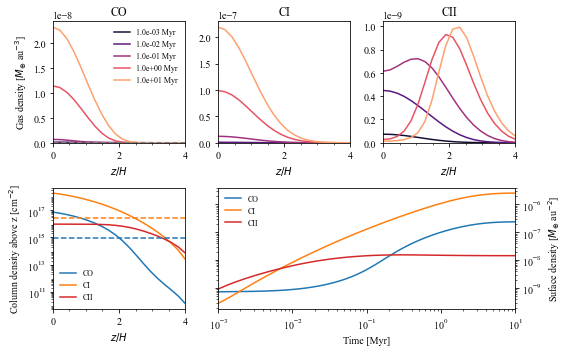

In [7]:
## let's plot now the surface density and mass evolution

# font size and style
font= {'family':'Times New Roman', 'size': 10}
rc('font', **font)

cmap=plt.get_cmap('magma')
vmin=0.1
vmax=0.8
Ntplot=len(ts_plot)
major_ticks_x=np.arange(0., 10.0, 2.0)
minor_ticks_x=np.arange(0., 10.0, 0.5)


fig=plt.figure(figsize=(8,5.))
ax1=fig.add_subplot(231)
ax2=fig.add_subplot(232)
ax3=fig.add_subplot(233)
ax4=fig.add_subplot(234)

gs = fig.add_gridspec(2,3)
ax5=fig.add_subplot(gs[1, 1:])


for it, ti in enumerate(ts_plot):

    ## find right epoch
    for j in range(sim.Nt2):
        if sim.ts[j]>=ti:
            break
    # plot the right epoch
    x=vmin+(vmax-vmin)*it/(Ntplot-1.)
    colori=cmap(x)
    # colori=fgeneral.fcolor_blue_red(it, Ntplot)
   
    ax1.plot(sim.zs/sim.H, sim.rhos[0,:,j], color=colori, label='%1.1e'%(ts_plot[it]/1.0e6)+' Myr')
    ax2.plot(sim.zs/sim.H, sim.rhos[1,:,j], color=colori)
    ax3.plot(sim.zs/sim.H, sim.rhos[2,:,j], color=colori)

ax1.plot(sim.zs/sim.H,sim.rho_eq_unshielded, ls='--', color='grey')

NCOs=np.cumsum(sim.rhos[0,::-1,-1])[::-1]*sim.dz*Mearth/au_cm**2/(28.*mp)
NCIs=np.cumsum(sim.rhos[1,::-1,-1])[::-1]*sim.dz*Mearth/au_cm**2/(12.*mp)
NCIIs=np.cumsum(sim.rhos[2,::-1,-1])[::-1]*sim.dz*Mearth/au_cm**2/(12.*mp)

ax4.plot(sim.zs[:]/sim.H,NCOs, color='C0', label='CO')
ax4.plot(sim.zs[:]/sim.H,NCIs, color='C1', label='CI')
ax4.plot(sim.zs[:]/sim.H,NCIIs, color='C3', label='CII')

ax4.axhline(NCO_midplane/2., color='C0', ls='--')
ax4.axhline(NCI_midplane/2., color='C1', ls='--')

Sigmas=2*np.sum(sim.rhos[:,1:,:]*sim.dz, axis=1)+sim.rhos[:,0,:]*sim.dz # N emisphere + midplane 

ax5.plot(sim.ts/1.0e6, Sigmas[0,:], color='C0', label='CO' )
ax5.plot(sim.ts/1.0e6, Sigmas[1,:], color='C1', label='CI')
ax5.plot(sim.ts/1.0e6, Sigmas[2,:], color='C3', label='CII')


axs=[ax1,ax2,ax3, ax4]
for i, axi in enumerate(axs):
    axi.set_xticks(major_ticks_x)                                                       
    axi.set_xticks(minor_ticks_x, minor=True)
    axi.set_xlim(0, sim.zmax/sim.H)
    if axi!=ax4: axi.set_ylim(0.,)
    axi.set_xlabel(r'$z/H$')

ax1.set_ylabel(r'Gas density [$M_{\oplus}$ au$^{-3}$]')
ax4.set_ylabel(r'Column density above z [cm$^{-2}$]')
ax5.set_ylabel(r'Suface density [$M_{\oplus}$ au$^{-2}$]')
ax5.set_xlabel('Time [Myr]')
ax5.set_xlim(sim.ts[0]/1.0e6, sim.ts[-1]/1.0e6)

for axi in axs[:-1]:
    # axi.set_yscale('log')
    axi.ticklabel_format(scilimits=(0,0))
ax4.set_yscale('log')    
ax5.set_xscale('log')    
ax5.set_yscale('log')    
    
locmaj = matplotlib.ticker.LogLocator(base=10,numticks=8) 
locmin = matplotlib.ticker.LogLocator(base=10.0,subs=np.arange(2, 10) * .1,numticks=100) # subs=(0.2,0.4,0.6,0.8)
ax4.yaxis.set_major_locator(locmaj)
ax4.yaxis.set_minor_locator(locmin)
locmaj = matplotlib.ticker.LogLocator(base=10,numticks=8) 
locmin = matplotlib.ticker.LogLocator(base=10.0,subs=np.arange(2, 10) * .1,numticks=100) # subs=(0.2,0.4,0.6,0.8)
ax5.yaxis.set_major_locator(locmaj)
ax5.yaxis.set_minor_locator(locmin)


ax1.set_title('CO')
ax2.set_title('CI')
ax3.set_title('CII')
# ax4.set_title('Column densities')

ax1.legend(loc=1, frameon=False, ncol=1, fontsize=8)
ax4.legend(loc=3, frameon=False, ncol=1, fontsize=8)
ax5.legend(loc=2, frameon=False, ncol=1, fontsize=8)
ax5.yaxis.set_label_position("right")
ax5.yaxis.tick_right()
ax5.tick_params(which='both', left=True)

plt.tight_layout()

We can also use the built in function to plot the results using `sim.plot_panels` that returns a figure

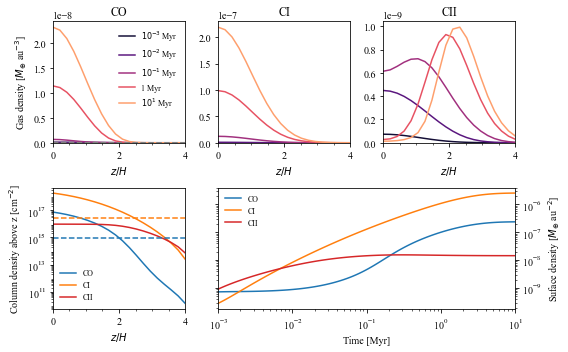

In [8]:
### EPOCHS TO PLOT
fig=sim.plot_panels(ts_plot)

# Customization

You can customize a few things depending on your needs. For example, you can increase the number of vertical cells and the maximum height with the parameters `Nz` and `zmax_to_H` (in units of $H$). By default these are set to 25 and 5. You can also change the sampling of the polar angle $\theta$ that is used to calculate the ionizating and photodissociating radiation iin different directions. By default `Ntheta` is set to 10.

Moreover, you can switch on and off the CO photodissociation, diffusion, ionization, and viscous evolution with the boolean parameters `photodissociation`, `diffusion`, `ionization`, and `viscous`.

In the example below I will change the resolution, increase the viscosity, lower the diffusion, set `tcoll` to $10^{6}$ yr so the CO input rate will be variable, set the `fir` and omit the CO input rate so the CO input rate will be calculated based on `fir` and `fco`, and define my own initial surface density.


In [ ]:
#### INITIALIZE SIMULATION
tcoll=1.0e6 # yr
fir=5.0e-3
sim=vsim.simulation(ts_out=np.logspace(3, np.log10(tf), Ntout), 
                    Mstar=Mstar,
                    Lstar=Lstar,
                    fco=fco,
                    rbelt=rbelt,
                    width=width,
                    alphar=1.0e-1,
                    alphav=1.0e-3,
                    fir=fir,
                    tcoll=tcoll,
                    Nz=50,
                    Ntheta=20,
                    )
#### RUN SIMULATION
print( 'Running simulation...')
T1=time.gmtime()
sim.vertical_evolution()
T2=time.gmtime()
print('Execution time in sec: ',time.mktime(T2)-time.mktime(T1)) 


  0%|          | 145/500000 [00:00<05:45, 1445.62it/s]

hey
varying CO input rate based on final fractional luminosity and tcoll given by the user
Zmax = 18.7 au
Nz = 50
Nt simulation=500001
simulation timestep = 20.0 yr
t_diffusion = 1.3e+05 yr
t_vis = 5.9e+05 yr
MdotCO at t=0 is 4.9e-05 Mearth/yr
MdotCO at t=1.0e+07 is 4.1e-07 Mearth/yr
SigmadotCO at t=1.0e+07 is 1.4e-11 Mearth/yr/au2
T = 49.5 K
Running simulation...


 79%|███████▉  | 396494/500000 [03:49<01:02, 1658.87it/s]

In [ ]:
### EPOCHS TO PLOT
ts_plot=np.logspace(3, int(np.log10(tf)), int(np.log10(tf))-3+1) # this will generate epochs from 1000 yr to tf in factors of 10
fig=sim.plot_panels(ts_plot)